In [1]:
import time
import argparse
import scipy.sparse as sp
import numpy as np
import torch
import ipdb
from scipy.io import loadmat
import networkx as nx
import multiprocessing as mp
import torch.nn.functional as F
from functools import partial
import random
from sklearn.metrics import roc_auc_score, f1_score
from copy import deepcopy
from scipy.spatial.distance import pdist,squareform
import torch.nn as nn
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn import init
import torch.optim as optim
import networkx as nx
import tensorflow as tf
import pandas as pd
from sklearn.metrics import roc_curve,roc_auc_score

In [2]:
def split_arti(labels, c_train_num):
    #labels: n-dim Longtensor, each element in [0,...,m-1].
    #cora: m=7
    num_classes = len(set(labels.tolist()))
    c_idxs = [] # class-wise index
    train_idx = []
    val_idx = []
    test_idx = []
    c_num_mat = np.zeros((num_classes,3)).astype(int)
    c_num_mat[:,1] = 25
    c_num_mat[:,2] = 55

    for i in range(num_classes):
        c_idx = (labels==i).nonzero()[:,-1].tolist()
        print('{:d}-th class sample number: {:d}'.format(i,len(c_idx)))
        random.shuffle(c_idx)
        c_idxs.append(c_idx)

        train_idx = train_idx + c_idx[:c_train_num[i]]
        c_num_mat[i,0] = c_train_num[i]

        val_idx = val_idx + c_idx[c_train_num[i]:(c_train_num[i]+int(c_train_num[i]*.2))]
        test_idx = test_idx + c_idx[int(c_train_num[i]+(c_train_num[i]*.2)):]

    random.shuffle(train_idx)

    #ipdb.set_trace()

    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    test_idx = torch.LongTensor(test_idx)
    #c_num_mat = torch.LongTensor(c_num_mat)


    return train_idx, val_idx, test_idx, c_num_mat


In [3]:
def src_upsample(adj,features,labels,idx_train, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    adj_back = adj
    chosen = None

    #ipdb.set_trace()
    avg_number = int(idx_train.shape[0]/(c_largest+1))

    for i in range(im_class_num):
        new_chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        if portion == 0:#refers to even distribution
            c_portion = int(avg_number/new_chosen.shape[0])

            for j in range(c_portion):
                if chosen is None:
                    chosen = new_chosen
                else:
                    chosen = torch.cat((chosen, new_chosen), 0)

        else:
            c_portion = int(portion)
            portion_rest = portion-c_portion
            for j in range(c_portion):
                num = int(new_chosen.shape[0])
                new_chosen = new_chosen[:num]

                if chosen is None:
                    chosen = new_chosen
                else:
                    chosen = torch.cat((chosen, new_chosen), 0)
            
            num = int(new_chosen.shape[0]*portion_rest)
            new_chosen = new_chosen[:num]

            if chosen is None:
                chosen = new_chosen
            else:
                chosen = torch.cat((chosen, new_chosen), 0)
            

    add_num = chosen.shape[0]
    new_adj = adj_back.new(torch.Size((adj_back.shape[0]+add_num, adj_back.shape[0]+add_num)))
    new_adj[:adj_back.shape[0], :adj_back.shape[0]] = adj_back[:,:]
    new_adj[adj_back.shape[0]:, :adj_back.shape[0]] = adj_back[chosen,:]
    new_adj[:adj_back.shape[0], adj_back.shape[0]:] = adj_back[:,chosen]
    new_adj[adj_back.shape[0]:, adj_back.shape[0]:] = adj_back[chosen,:][:,chosen]

    #ipdb.set_trace()
    features_append = deepcopy(features[chosen,:])
    labels_append = deepcopy(labels[chosen])
    idx_new = np.arange(adj_back.shape[0], adj_back.shape[0]+add_num)
    idx_train_append = idx_train.new(idx_new)

    features = torch.cat((features,features_append), 0)
    labels = torch.cat((labels,labels_append), 0)
    idx_train = torch.cat((idx_train,idx_train_append), 0)
    adj = new_adj

    return adj, features, labels, idx_train

In [4]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        #for 3_D batch, need a loop!!!


        if self.bias is not None:
            return output + self.bias
        else:
            return output

#Multihead attention layer
class MultiHead(Module):#currently, allowed for only one sample each time. As no padding mask is required.
    def __init__(
        self,
        input_dim,
        num_heads,
        kdim=None,
        vdim=None,
        embed_dim = 128,#should equal num_heads*head dim
        v_embed_dim = None,
        dropout=0.1,
        bias=True,
    ):
        super(MultiHead, self).__init__()
        self.input_dim = input_dim
        self.kdim = kdim if kdim is not None else input_dim
        self.vdim = vdim if vdim is not None else input_dim
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.v_embed_dim = v_embed_dim if v_embed_dim is not None else embed_dim

        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        self.bias = bias
        assert (
            self.head_dim * num_heads == self.embed_dim
        ), "embed_dim must be divisible by num_heads"

        assert self.v_embed_dim % num_heads ==0, "v_embed_dim must be divisible by num_heads"

        self.scaling = self.head_dim ** -0.5


        self.q_proj = nn.Linear(self.input_dim, self.embed_dim, bias=bias)
        self.k_proj = nn.Linear(self.kdim, self.embed_dim, bias=bias)
        self.v_proj = nn.Linear(self.vdim, self.v_embed_dim, bias=bias)

        self.out_proj = nn.Linear(self.v_embed_dim, self.v_embed_dim//self.num_heads, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        if True:
            # Empirically observed the convergence to be much better with
            # the scaled initialization
            nn.init.normal_(self.k_proj.weight)
            nn.init.normal_(self.v_proj.weight)
            nn.init.normal_(self.q_proj.weight)
        else:
            nn.init.normal_(self.k_proj.weight)
            nn.init.normal_(self.v_proj.weight)
            nn.init.normal_(self.q_proj.weight)

        nn.init.normal_(self.out_proj.weight)

        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0.)

        if self.bias:
            nn.init.constant_(self.k_proj.bias, 0.)
            nn.init.constant_(self.v_proj.bias, 0.)
            nn.init.constant_(self.q_proj.bias, 0.)

    def forward(
        self,
        query,
        key,
        value,
        need_weights: bool = False,
        need_head_weights: bool = False,
    ):
        """Input shape: Time x Batch x Channel
        Args:
            need_weights (bool, optional): return the attention weights,
                averaged over heads (default: False).
            need_head_weights (bool, optional): return the attention
                weights for each head. Implies *need_weights*. Default:
                return the average attention weights over all heads.
        """
        if need_head_weights:
            need_weights = True

        batch_num, node_num, input_dim = query.size()

        assert key is not None and value is not None

        #project input
        q = self.q_proj(query)
        k = self.k_proj(key)
        v = self.v_proj(value)
        q = q * self.scaling

        #compute attention
        q = q.view(batch_num, node_num, self.num_heads, self.head_dim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.head_dim)
        k = k.view(batch_num, node_num, self.num_heads, self.head_dim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.head_dim)
        v = v.view(batch_num, node_num, self.num_heads, self.vdim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.vdim)
        attn_output_weights = torch.bmm(q, k.transpose(-1,-2))
        attn_output_weights = F.softmax(attn_output_weights, dim=-1)

        #drop out
        attn_output_weights = F.dropout(attn_output_weights, p=self.dropout, training=self.training)

        #collect output
        attn_output = torch.bmm(attn_output_weights, v)
        attn_output = attn_output.view(batch_num, self.num_heads, node_num, self.vdim).transpose(-2,-3).contiguous().view(batch_num, node_num, self.v_embed_dim)
        attn_output = self.out_proj(attn_output)


        if need_weights:
            attn_output_weights = attn_output_weights #view: (batch_num, num_heads, node_num, node_num)
            return attn_output, attn_output_weights.sum(dim=1) / self.num_heads
        else:
            return attn_output


#Graphsage layer
class SageConv(Module):
    """
    Simple Graphsage layer
    """

    def __init__(self, in_features, out_features, bias=False):
        super(SageConv, self).__init__()

        self.proj = nn.Linear(in_features*2, out_features, bias=bias)

        self.reset_parameters()

        #print("note: for dense graph in graphsage, require it normalized.")

    def reset_parameters(self):

        nn.init.normal_(self.proj.weight)

        if self.proj.bias is not None:
            nn.init.constant_(self.proj.bias, 0.)

    def forward(self, features, adj):
        """
        Args:
            adj: can be sparse or dense matrix.
        """

        #fuse info from neighbors. to be added:
        if not isinstance(adj, torch.sparse.FloatTensor):
            if len(adj.shape) == 3:
                neigh_feature = torch.bmm(adj, features) / (adj.sum(dim=1).reshape((adj.shape[0], adj.shape[1],-1))+1)
            else:
                neigh_feature = torch.mm(adj, features) / (adj.sum(dim=1).reshape(adj.shape[0], -1)+1)
        else:
            #print("spmm not implemented for batch training. Note!")
            
            neigh_feature = torch.spmm(adj, features) / (adj.to_dense().sum(dim=1).reshape(adj.shape[0], -1)+1)

        #perform conv
        data = torch.cat([features,neigh_feature], dim=-1)
        combined = self.proj(data)

        return combined

#GraphAT layers

class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        if isinstance(adj, torch.sparse.FloatTensor):
            adj = adj.to_dense()

        h = torch.mm(input, self.W)
        N = h.size()[0]

        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


class SpecialSpmmFunction(torch.autograd.Function):
    """Special function for only sparse region backpropataion layer."""
    @staticmethod
    def forward(ctx, indices, values, shape, b):
        assert indices.requires_grad == False
        a = torch.sparse_coo_tensor(indices, values, shape)
        ctx.save_for_backward(a, b)
        ctx.N = shape[0]
        return torch.matmul(a, b)

    @staticmethod
    def backward(ctx, grad_output):
        a, b = ctx.saved_tensors
        grad_values = grad_b = None
        if ctx.needs_input_grad[1]:
            grad_a_dense = grad_output.matmul(b.t())
            edge_idx = a._indices()[0, :] * ctx.N + a._indices()[1, :]
            grad_values = grad_a_dense.view(-1)[edge_idx]
        if ctx.needs_input_grad[3]:
            grad_b = a.t().matmul(grad_output)
        return None, grad_values, None, grad_b


class SpecialSpmm(nn.Module):
    def forward(self, indices, values, shape, b):
        return SpecialSpmmFunction.apply(indices, values, shape, b)

    
class SpGraphAttentionLayer(nn.Module):
    """
    Sparse version GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(SpGraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_normal_(self.W.data, gain=1.414)
                
        self.a = nn.Parameter(torch.zeros(size=(1, 2*out_features)))
        nn.init.xavier_normal_(self.a.data, gain=1.414)

        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.special_spmm = SpecialSpmm()

    def forward(self, input, adj):
        dv = 'cuda' if input.is_cuda else 'cpu'

        N = input.size()[0]
        edge = adj.nonzero().t()

        h = torch.mm(input, self.W)
        # h: N x out
        assert not torch.isnan(h).any()

        # Self-attention on the nodes - Shared attention mechanism
        edge_h = torch.cat((h[edge[0, :], :], h[edge[1, :], :]), dim=1).t()
        # edge: 2*D x E

        edge_e = torch.exp(-self.leakyrelu(self.a.mm(edge_h).squeeze()))
        assert not torch.isnan(edge_e).any()
        # edge_e: E

        e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N,1), device=dv))
        # e_rowsum: N x 1

        edge_e = self.dropout(edge_e)
        # edge_e: E

        h_prime = self.special_spmm(edge, edge_e, torch.Size([N, N]), h)
        assert not torch.isnan(h_prime).any()
        # h_prime: N x out
        
        h_prime = h_prime.div(e_rowsum)
        # h_prime: N x out
        assert not torch.isnan(h_prime).any()

        if self.concat:
            # if this layer is not last layer,
            return F.elu(h_prime)
        else:
            # if this layer is last layer,
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'




#--------------
### models ###
#--------------

#gcn_encode
class GCN_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(GCN_En, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class GCN_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(GCN_En2, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

class GCN_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(GCN_Classifier, self).__init__()

        self.gc1 = GraphConvolution(nembed, nhid)
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)

        return x

#sage model

class Sage_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(Sage_En, self).__init__()

        self.sage1 = SageConv(nfeat, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

class Sage_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(Sage_En2, self).__init__()

        self.sage1 = SageConv(nfeat, nhid)
        self.sage2 = SageConv(nhid, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.sage2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class Sage_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(Sage_Classifier, self).__init__()

        self.sage1 = SageConv(nembed, nhid)
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)

        return x


#GAT model

class GAT_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout, alpha=0.2, nheads=8):
        super(GAT_En, self).__init__()

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nembed)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.out_proj.weight,std=0.05)

    def forward(self, x, adj):

        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))

        return x

class GAT_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout, alpha=0.2, nheads=8):
        super(GAT_En2, self).__init__()

        
        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nembed)
        self.dropout = dropout

        self.attentions_2 = [GraphAttentionLayer(nembed, nembed, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions_2):
            self.add_module('attention2_{}'.format(i), attention)

        self.out_proj_2 = nn.Linear(nembed * nheads, nembed)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.out_proj.weight,std=0.05)
        nn.init.normal_(self.out_proj_2.weight,std=0.05)


    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))
        x = torch.cat([att(x, adj) for att in self.attentions_2], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj_2(x))
        return x

class GAT_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout, alpha=0.2, nheads=8):
        super(GAT_Classifier, self).__init__()

        
        self.attentions = [GraphAttentionLayer(nembed, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nhid)

        self.dropout = dropout
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)
        nn.init.normal_(self.out_proj.weight,std=0.05)

    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))
        x = self.mlp(x)

        return x


class Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(Classifier, self).__init__()

        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = self.mlp(x)

        return x

class Decoder(Module):
    """
    Simple Graphsage layer
    """

    def __init__(self, nembed, dropout=0.1):
        super(Decoder, self).__init__()
        self.dropout = dropout

        self.de_weight = Parameter(torch.FloatTensor(nembed, nembed))

        self.reset_parameters()


    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.de_weight.size(1))
        self.de_weight.data.uniform_(-stdv, stdv)


    def forward(self, node_embed):
        
        combine = F.linear(node_embed, self.de_weight)
        adj_out = torch.sigmoid(torch.mm(combine, combine.transpose(-1,-2)))

        return adj_out

In [5]:
def split_genuine(labels):
    #labels: n-dim Longtensor, each element in [0,...,m-1].
    #cora: m=7
    num_classes = len(set(labels.tolist()))
    c_idxs = [] # class-wise index
    train_idx = []
    val_idx = []
    test_idx = []
    c_num_mat = np.zeros((num_classes,3)).astype(int)

    for i in range(num_classes):
        c_idx = (labels==i).nonzero()[:,-1].tolist()
        c_num = len(c_idx)
        print('{:d}-th class sample number: {:d}'.format(i,len(c_idx)))
        random.shuffle(c_idx)
        c_idxs.append(c_idx)

        if c_num <4:
            if c_num < 3:
                print("too small class type")
                ipdb.set_trace()
            c_num_mat[i,0] = 1
            c_num_mat[i,1] = 1
            c_num_mat[i,2] = 1
        else:
            c_num_mat[i,0] = int(c_num/4)
            c_num_mat[i,1] = int(c_num/4)
            c_num_mat[i,2] = int(c_num/2)


        train_idx = train_idx + c_idx[:c_num_mat[i,0]]

        val_idx = val_idx + c_idx[c_num_mat[i,0]:c_num_mat[i,0]+c_num_mat[i,1]]
        test_idx = test_idx + c_idx[c_num_mat[i,0]+c_num_mat[i,1]:c_num_mat[i,0]+c_num_mat[i,1]+c_num_mat[i,2]]

    random.shuffle(train_idx)

    #ipdb.set_trace()

    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    test_idx = torch.LongTensor(test_idx)
    #c_num_mat = torch.LongTensor(c_num_mat)


    return train_idx, val_idx, test_idx, c_num_mat


In [6]:
data=pd.read_csv("interactions_smote.csv")
Graphtype = nx.Graph()
data['edge']=data['Gene Symbol']+',' +data['Interactor Symbol']
data['edge']=data['edge'].astype(str)
g = nx.parse_edgelist(data['edge'], delimiter=',', create_using=Graphtype,)
adj=nx.adjacency_matrix(g,weight=None)
adj=adj.toarray()

C:\Users\Kyler\AppData\Local\Temp\ipykernel_35120\1883115882.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj=nx.adjacency_matrix(g,weight=None)


In [7]:
#node_features = np.loadtxt('node_features_smote.txt')
node_features = np.ones((adj.shape[0],1))
labels = np.loadtxt('Labels.txt')


In [8]:
labels=torch.LongTensor(labels)
features=torch.LongTensor(node_features)
adj=torch.LongTensor(adj)
class_sample_num = 4000
c_train_num = []
for i in range(labels.max().item() + 1):
    if i > labels.max().item()-1: #only imbalance the last classes
        c_train_num.append(int(class_sample_num))

    else:
        c_train_num.append(class_sample_num)

In [9]:
for i in range(4):
    idx_train, idx_val, idx_test, class_num_mat= split_arti(labels, c_train_num)
    adj,features,labels,idx_train = src_upsample(adj,features,labels,idx_train,portion=1, im_class_num=1)


0-th class sample number: 9535
1-th class sample number: 743
0-th class sample number: 9535
1-th class sample number: 1486
0-th class sample number: 9535
1-th class sample number: 2972
0-th class sample number: 9535
1-th class sample number: 5944


In [10]:
idx_train, idx_val, idx_test, class_num_mat= split_arti(labels, c_train_num)

0-th class sample number: 9535
1-th class sample number: 9944


In [11]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [12]:
encoder = Sage_En(nfeat=features.shape[1],
        nhid=4096,
        nembed=4096,
        dropout=.1)
classifier = Sage_Classifier(nembed=4096, 
        nhid=4096, 
        nclass=labels.max().item() + 1, 
        dropout=.1)
decoder = Decoder(nembed=4096,
        dropout=.1)


optimizer_en = optim.Adam(encoder.parameters(),
                       lr=0.001, weight_decay=5e-4)
optimizer_cls = optim.Adam(classifier.parameters(),
                       lr=0.001, weight_decay=5e-4)
optimizer_de = optim.Adam(decoder.parameters(),
                       lr=0.001, weight_decay=5e-4)


In [13]:
features.shape[1]

1

In [14]:
def recon_upsample(embed, labels, idx_train, adj=None, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    avg_number = int(idx_train.shape[0]/(c_largest+1))
    #ipdb.set_trace()
    adj_new = None

    for i in range(im_class_num):
        chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        num = int(chosen.shape[0]*portion)
        if portion == 0:
            c_portion = int(avg_number/chosen.shape[0])
            num = chosen.shape[0]
        else:
            c_portion = 1

        for j in range(c_portion):
            chosen = chosen[:num]

            chosen_embed = embed[chosen,:]
            distance = squareform(pdist(chosen_embed.detach()))
            np.fill_diagonal(distance,distance.max()+100)

            idx_neighbor = distance.argmin(axis=-1)
            
            interp_place = random.random()
            new_embed = embed[chosen,:] + (chosen_embed[idx_neighbor[:],:]-embed[chosen,:])*interp_place


            new_labels = labels.new(torch.Size((chosen.shape[0],1))).reshape(-1).fill_(c_largest-i)
            idx_new = np.arange(embed.shape[0], embed.shape[0]+chosen.shape[0])
            idx_train_append = idx_train.new(idx_new)

            embed = torch.cat((embed,new_embed), 0)
            labels = torch.cat((labels,new_labels), 0)
            idx_train = torch.cat((idx_train,idx_train_append), 0)

            if adj is not None:
                if adj_new is None:
                    adj_new = adj.new(torch.clamp(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                else:
                    temp = adj.new(torch.clamp(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                    adj_new = torch.cat((adj_new, temp), 0)

    if adj is not None:
        add_num = adj_new.shape[0]
        new_adj = adj.new(torch.Size((adj.shape[0]+add_num, adj.shape[0]+add_num))).fill_(0.0)
        new_adj[:adj.shape[0], :adj.shape[0]] = adj[:,:]
        new_adj[adj.shape[0]:, :adj.shape[0]] = adj_new[:,:]
        new_adj[:adj.shape[0], adj.shape[0]:] = torch.transpose(adj_new, 0, 1)[:,:]

        return embed, labels, idx_train, new_adj.detach()

    else:
        return embed, labels, idx_train

In [15]:
def train(epoch,accuracy_train_lst,loss_train_lst,accuracy_val_lst,loss_val_lst):
    t = time.time()
    encoder.train()
    classifier.train()
    decoder.train()
    optimizer_en.zero_grad()
    optimizer_cls.zero_grad()
    optimizer_de.zero_grad()
    print(features.shape)
    embed = encoder(features, adj)

    #perform SMOTE in embedding space
    labels_new = labels
    idx_train_new = idx_train
    adj_new = adj

   
    #ipdb.set_trace()
    output = classifier(embed, adj_new)

    loss_train = F.cross_entropy(output[idx_train_new], labels_new[idx_train_new])

    acc_train = accuracy(output[idx_train], labels_new[idx_train])
    loss = loss_train
    loss_rec = loss_train
    loss.backward()
    optimizer_en.step()

    optimizer_cls.step()

    loss_val = F.cross_entropy(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    accuracy_train_lst.append(acc_train)
    loss_train_lst.append(loss_train)
    accuracy_val_lst.append(acc_val)
    loss_val_lst.append(loss_val)
    print('Epoch: {:05d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'loss_rec: {:.4f}'.format(loss_rec.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    


def test(epoch = 0):
    encoder.eval()
    classifier.eval()
    decoder.eval()
    embed = encoder(features, adj)
    output = classifier(embed, adj)
    loss_test = F.cross_entropy(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

  

    '''
    if epoch==40:
        torch
    '''
    return output


def save_model(epoch):
    saved_content = {}

    saved_content['encoder'] = encoder.state_dict()
    saved_content['decoder'] = decoder.state_dict()
    saved_content['classifier'] = classifier.state_dict()

    torch.save(saved_content, 'model_checkpoint.pth')

    return

def load_model(filename):
    loaded_content = torch.load('checkpoint/{}/{}.pth')

    encoder.load_state_dict(loaded_content['encoder'])
    decoder.load_state_dict(loaded_content['decoder'])
    classifier.load_state_dict(loaded_content['classifier'])

    print("successfully loaded: "+ filename)

    return

In [16]:
encoder = encoder.cuda()
classifier = classifier.cuda()
decoder = decoder.cuda()
labels = labels.cuda()
idx_train = idx_train.cuda()
idx_val = idx_val.cuda()
idx_test = idx_test.cuda()

In [17]:
adj = torch.tensor(adj, dtype=torch.float)
features = torch.tensor(features, dtype=torch.float)
features = features.cuda()
adj = adj.cuda()
accuracy_train_lst=[]
loss_train_lst=[]
accuracy_val_lst=[]
loss_val_lst=[]
t_total = time.time()
for epoch in range(400):
    train(epoch,accuracy_train_lst,loss_train_lst,accuracy_val_lst,loss_val_lst)
    if epoch % 10 == 0:
        output=test(epoch)

    if epoch % 100 == 0:
        save_model(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
output=test()

C:\Users\Kyler\AppData\Local\Temp\ipykernel_35120\3799076001.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(adj, dtype=torch.float)
C:\Users\Kyler\AppData\Local\Temp\ipykernel_35120\3799076001.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float)


torch.Size([19479, 1])
Epoch: 00001 loss_train: 197.6881 loss_rec: 197.6881 acc_train: 0.5001 loss_val: 200.1166 acc_val: 0.5000 time: 1.0325s
Test set results: loss= 190.5303 accuracy= 0.5207
torch.Size([19479, 1])
Epoch: 00002 loss_train: 206.9138 loss_rec: 206.9138 acc_train: 0.4999 loss_val: 208.1792 acc_val: 0.5000 time: 0.4350s
torch.Size([19479, 1])
Epoch: 00003 loss_train: 186.9822 loss_rec: 186.9822 acc_train: 0.4998 loss_val: 185.3225 acc_val: 0.5019 time: 0.4345s
torch.Size([19479, 1])
Epoch: 00004 loss_train: 46.5435 loss_rec: 46.5435 acc_train: 0.5071 loss_val: 49.3623 acc_val: 0.4756 time: 0.4285s
torch.Size([19479, 1])
Epoch: 00005 loss_train: 139.9810 loss_rec: 139.9810 acc_train: 0.5010 loss_val: 139.8519 acc_val: 0.5000 time: 0.4460s
torch.Size([19479, 1])
Epoch: 00006 loss_train: 148.1152 loss_rec: 148.1152 acc_train: 0.5004 loss_val: 147.9352 acc_val: 0.5025 time: 0.4295s
torch.Size([19479, 1])
Epoch: 00007 loss_train: 76.4320 loss_rec: 76.4320 acc_train: 0.4856 los

Epoch: 00058 loss_train: 40.7388 loss_rec: 40.7388 acc_train: 0.4966 loss_val: 41.4906 acc_val: 0.5100 time: 0.4291s
torch.Size([19479, 1])
Epoch: 00059 loss_train: 37.3969 loss_rec: 37.3969 acc_train: 0.5312 loss_val: 39.3464 acc_val: 0.5212 time: 0.4260s
torch.Size([19479, 1])
Epoch: 00060 loss_train: 38.5732 loss_rec: 38.5732 acc_train: 0.5134 loss_val: 37.5922 acc_val: 0.5262 time: 0.4290s
torch.Size([19479, 1])
Epoch: 00061 loss_train: 36.4151 loss_rec: 36.4151 acc_train: 0.5434 loss_val: 36.0216 acc_val: 0.5450 time: 0.4260s
Test set results: loss= 6.7436 accuracy= 0.5191
torch.Size([19479, 1])
Epoch: 00062 loss_train: 40.1318 loss_rec: 40.1318 acc_train: 0.5120 loss_val: 40.9136 acc_val: 0.4900 time: 0.4470s
torch.Size([19479, 1])
Epoch: 00063 loss_train: 38.3306 loss_rec: 38.3306 acc_train: 0.5126 loss_val: 37.6511 acc_val: 0.5381 time: 0.4405s
torch.Size([19479, 1])
Epoch: 00064 loss_train: 38.0405 loss_rec: 38.0405 acc_train: 0.5239 loss_val: 36.5046 acc_val: 0.5319 time: 0.4

Epoch: 00115 loss_train: 35.8713 loss_rec: 35.8713 acc_train: 0.5125 loss_val: 36.4099 acc_val: 0.5038 time: 0.4300s
torch.Size([19479, 1])
Epoch: 00116 loss_train: 34.4121 loss_rec: 34.4121 acc_train: 0.5192 loss_val: 36.7573 acc_val: 0.5188 time: 0.4285s
torch.Size([19479, 1])
Epoch: 00117 loss_train: 33.7435 loss_rec: 33.7435 acc_train: 0.5519 loss_val: 31.0282 acc_val: 0.5569 time: 0.4290s
torch.Size([19479, 1])
Epoch: 00118 loss_train: 33.6768 loss_rec: 33.6768 acc_train: 0.5396 loss_val: 32.7472 acc_val: 0.5369 time: 0.4320s
torch.Size([19479, 1])
Epoch: 00119 loss_train: 36.0066 loss_rec: 36.0066 acc_train: 0.5226 loss_val: 37.0141 acc_val: 0.5244 time: 0.4300s
torch.Size([19479, 1])
Epoch: 00120 loss_train: 34.6800 loss_rec: 34.6800 acc_train: 0.5334 loss_val: 35.6794 acc_val: 0.5062 time: 0.4305s
torch.Size([19479, 1])
Epoch: 00121 loss_train: 33.4013 loss_rec: 33.4013 acc_train: 0.5378 loss_val: 31.2410 acc_val: 0.5463 time: 0.4295s
Test set results: loss= 4.8329 accuracy= 0.

Epoch: 00172 loss_train: 33.6301 loss_rec: 33.6301 acc_train: 0.5188 loss_val: 35.3013 acc_val: 0.5231 time: 0.4310s
torch.Size([19479, 1])
Epoch: 00173 loss_train: 28.8191 loss_rec: 28.8191 acc_train: 0.5489 loss_val: 29.8398 acc_val: 0.5469 time: 0.4330s
torch.Size([19479, 1])
Epoch: 00174 loss_train: 30.0400 loss_rec: 30.0400 acc_train: 0.5487 loss_val: 31.6124 acc_val: 0.5463 time: 0.4340s
torch.Size([19479, 1])
Epoch: 00175 loss_train: 29.7952 loss_rec: 29.7952 acc_train: 0.5308 loss_val: 30.0675 acc_val: 0.5262 time: 0.4355s
torch.Size([19479, 1])
Epoch: 00176 loss_train: 29.8874 loss_rec: 29.8874 acc_train: 0.5424 loss_val: 27.7995 acc_val: 0.5537 time: 0.4401s
torch.Size([19479, 1])
Epoch: 00177 loss_train: 30.6533 loss_rec: 30.6533 acc_train: 0.5366 loss_val: 30.1174 acc_val: 0.5388 time: 0.4300s
torch.Size([19479, 1])
Epoch: 00178 loss_train: 28.8062 loss_rec: 28.8062 acc_train: 0.5564 loss_val: 30.2823 acc_val: 0.5475 time: 0.4360s
torch.Size([19479, 1])
Epoch: 00179 loss_tr

Epoch: 00229 loss_train: 29.2970 loss_rec: 29.2970 acc_train: 0.5671 loss_val: 29.9872 acc_val: 0.5537 time: 0.4325s
torch.Size([19479, 1])
Epoch: 00230 loss_train: 30.7648 loss_rec: 30.7648 acc_train: 0.5211 loss_val: 29.3601 acc_val: 0.5281 time: 0.4315s
torch.Size([19479, 1])
Epoch: 00231 loss_train: 26.3452 loss_rec: 26.3452 acc_train: 0.5511 loss_val: 27.1207 acc_val: 0.5531 time: 0.4285s
Test set results: loss= 7.6229 accuracy= 0.7095
torch.Size([19479, 1])
Epoch: 00232 loss_train: 25.2397 loss_rec: 25.2397 acc_train: 0.5633 loss_val: 23.6456 acc_val: 0.5700 time: 0.4325s
torch.Size([19479, 1])
Epoch: 00233 loss_train: 27.2048 loss_rec: 27.2048 acc_train: 0.5597 loss_val: 28.0548 acc_val: 0.5663 time: 0.4320s
torch.Size([19479, 1])
Epoch: 00234 loss_train: 25.0201 loss_rec: 25.0201 acc_train: 0.5617 loss_val: 25.9999 acc_val: 0.5394 time: 0.4305s
torch.Size([19479, 1])
Epoch: 00235 loss_train: 26.5135 loss_rec: 26.5135 acc_train: 0.5739 loss_val: 28.1434 acc_val: 0.5637 time: 0.4

Epoch: 00286 loss_train: 26.5650 loss_rec: 26.5650 acc_train: 0.5639 loss_val: 26.4673 acc_val: 0.5487 time: 0.4485s
torch.Size([19479, 1])
Epoch: 00287 loss_train: 24.3591 loss_rec: 24.3591 acc_train: 0.5440 loss_val: 23.8149 acc_val: 0.5525 time: 0.4455s
torch.Size([19479, 1])
Epoch: 00288 loss_train: 25.7087 loss_rec: 25.7087 acc_train: 0.5480 loss_val: 26.6177 acc_val: 0.5325 time: 0.4405s
torch.Size([19479, 1])
Epoch: 00289 loss_train: 21.5185 loss_rec: 21.5185 acc_train: 0.5809 loss_val: 22.9091 acc_val: 0.5644 time: 0.4341s
torch.Size([19479, 1])
Epoch: 00290 loss_train: 28.9478 loss_rec: 28.9478 acc_train: 0.5371 loss_val: 29.0999 acc_val: 0.5300 time: 0.4435s
torch.Size([19479, 1])
Epoch: 00291 loss_train: 22.9022 loss_rec: 22.9022 acc_train: 0.5629 loss_val: 21.7245 acc_val: 0.5731 time: 0.4460s
Test set results: loss= 16.2544 accuracy= 0.5443
torch.Size([19479, 1])
Epoch: 00292 loss_train: 29.4504 loss_rec: 29.4504 acc_train: 0.5496 loss_val: 30.0124 acc_val: 0.5519 time: 0.

Epoch: 00343 loss_train: 21.6781 loss_rec: 21.6781 acc_train: 0.5811 loss_val: 22.4619 acc_val: 0.5694 time: 0.4355s
torch.Size([19479, 1])
Epoch: 00344 loss_train: 24.2311 loss_rec: 24.2311 acc_train: 0.5626 loss_val: 23.1380 acc_val: 0.5713 time: 0.4355s
torch.Size([19479, 1])
Epoch: 00345 loss_train: 23.3199 loss_rec: 23.3199 acc_train: 0.5651 loss_val: 21.1901 acc_val: 0.5719 time: 0.4340s
torch.Size([19479, 1])
Epoch: 00346 loss_train: 20.2678 loss_rec: 20.2678 acc_train: 0.5821 loss_val: 20.0871 acc_val: 0.5825 time: 0.4335s
torch.Size([19479, 1])
Epoch: 00347 loss_train: 19.7705 loss_rec: 19.7705 acc_train: 0.5943 loss_val: 20.3214 acc_val: 0.5931 time: 0.4335s
torch.Size([19479, 1])
Epoch: 00348 loss_train: 22.0665 loss_rec: 22.0665 acc_train: 0.5679 loss_val: 21.7966 acc_val: 0.5775 time: 0.4395s
torch.Size([19479, 1])
Epoch: 00349 loss_train: 20.1274 loss_rec: 20.1274 acc_train: 0.5721 loss_val: 19.1194 acc_val: 0.5919 time: 0.4425s
torch.Size([19479, 1])
Epoch: 00350 loss_tr

Epoch: 00400 loss_train: 18.5544 loss_rec: 18.5544 acc_train: 0.5767 loss_val: 20.0587 acc_val: 0.5713 time: 0.4320s
Optimization Finished!
Total time elapsed: 183.4388s
Test set results: loss= 9.4057 accuracy= 0.6296


In [18]:
len(idx_train)

8000

In [19]:
len(idx_val)

1600

In [20]:
len(idx_test)

9879

In [21]:
preds = output.max(1)[1].type_as(labels)
cout=preds.cpu().detach().numpy()
clabels=labels.cpu().detach().numpy()
cidx_test=idx_test.cpu().detach().numpy()
cidx_valid=idx_val.cpu().detach().numpy()

Text(0.5, 427.9555555555555, 'Predicted label')

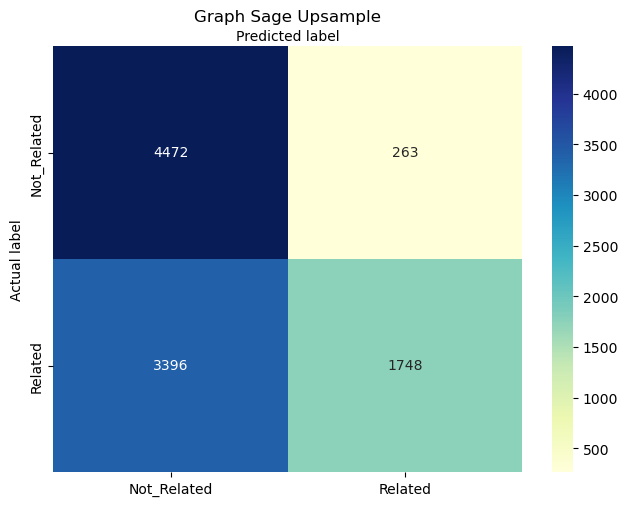

In [22]:
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt 
cnf_matrix_n = metrics.confusion_matrix(clabels[cidx_test], cout[cidx_test])
class_names=["Not_Related", "Related"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(cnf_matrix_n, annot=True, cmap="YlGnBu" ,fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Graph Sage Upsample')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 427.9555555555555, 'Predicted label')

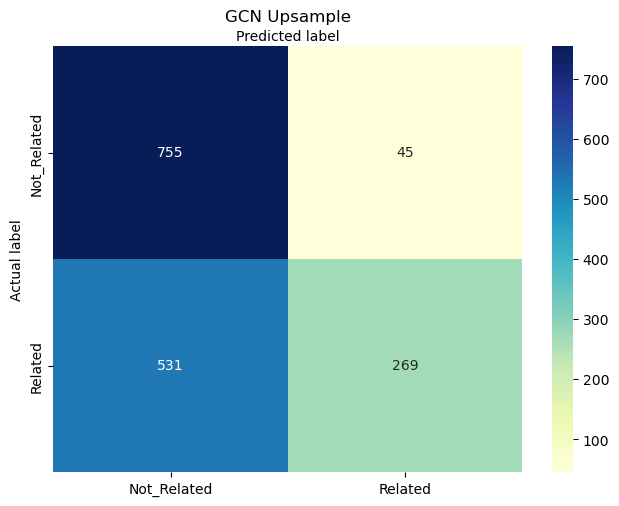

In [23]:
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
cnf_matrix_n_valid = metrics.confusion_matrix(clabels[cidx_valid], cout[cidx_valid])
class_names=["Not_Related", "Related"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(cnf_matrix_n_valid, annot=True, cmap="YlGnBu" ,fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('GCN Upsample')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [24]:
for i in range(len(loss_train_lst)):
    loss_train_lst[i]=loss_train_lst[i].detach().cpu().numpy()
for i in range(len(accuracy_train_lst)):
    accuracy_train_lst[i]=accuracy_train_lst[i].detach().cpu().numpy()
for i in range(len(loss_val_lst)):
    loss_val_lst[i]=loss_val_lst[i].detach().cpu().numpy()
for i in range(len(accuracy_val_lst)):
    accuracy_val_lst[i]=accuracy_val_lst[i].detach().cpu().numpy()
      


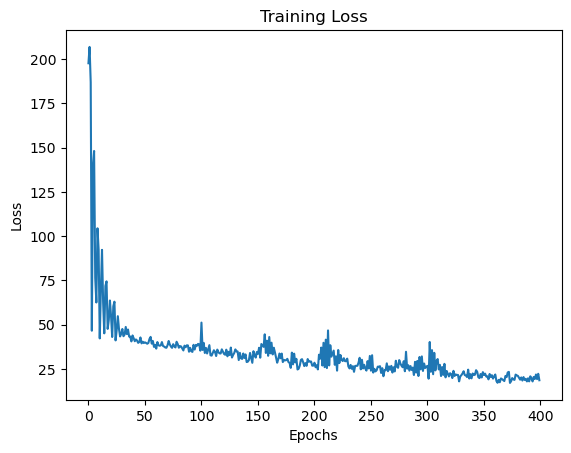

In [25]:
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_train_lst)

plt.show()

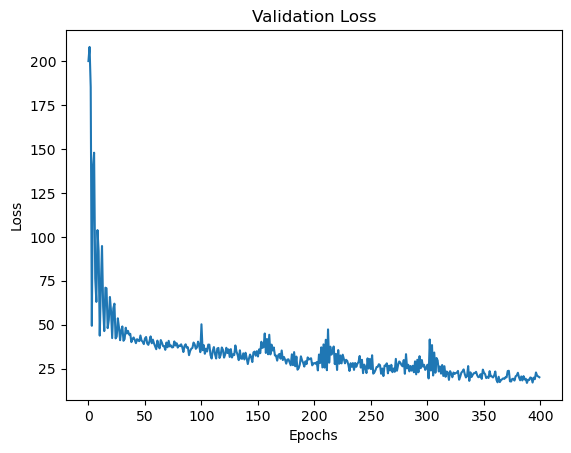

In [26]:
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_val_lst)

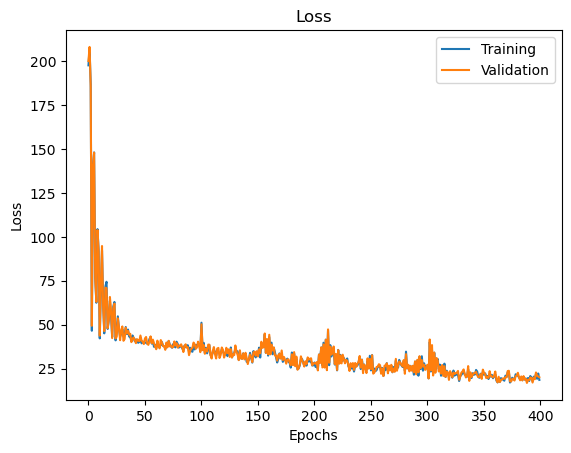

In [27]:
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_train_lst)
plt.plot(loss_val_lst)
plt.legend(['Training', 'Validation'])

plt.show()

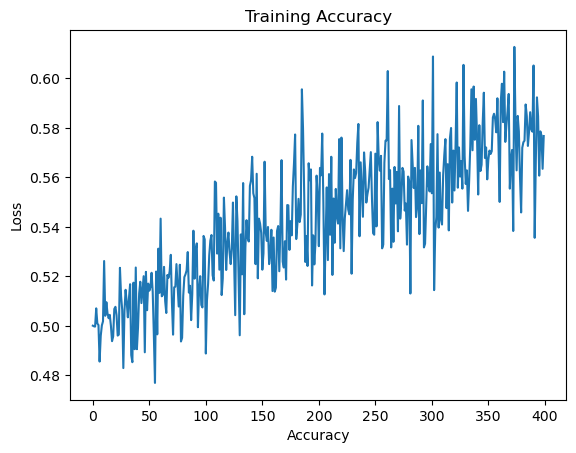

In [28]:
plt.title("Training Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Loss")
plt.plot(accuracy_train_lst)

plt.show()

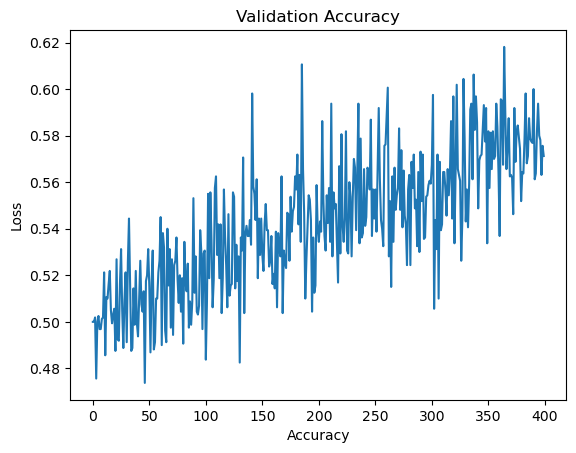

In [29]:
plt.title("Validation Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Loss")
plt.plot(accuracy_val_lst)

plt.show()

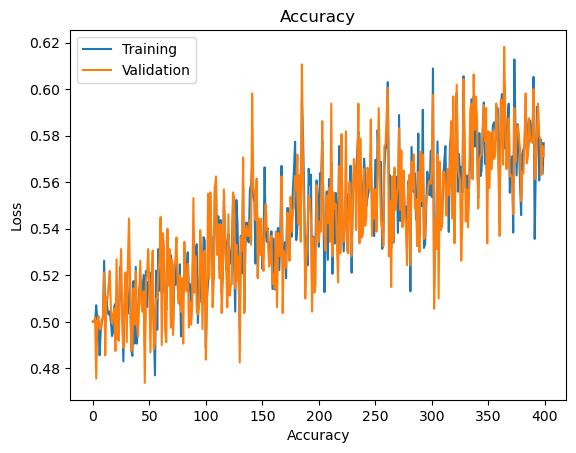

In [30]:
plt.title("Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Loss")
plt.plot(accuracy_train_lst)
plt.plot(accuracy_val_lst)
plt.legend(['Training', 'Validation'])

plt.show()

In [31]:
print('{:d}-th class sample number: {:d}'.format(1,len(idx_train)+len(idx_val)+len(idx_train)))

1-th class sample number: 17600


In [32]:
features

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], device='cuda:0')

In [33]:
false_positive_test=cnf_matrix_n[0][1]
true_positive_test=cnf_matrix_n[1][1]
true_negative_test=cnf_matrix_n[0][0]
false_negative_test=cnf_matrix_n[1][0]

false_positive_valid=cnf_matrix_n_valid[0][1]
true_positive_valid=cnf_matrix_n_valid[1][1]
true_negative_valid=cnf_matrix_n_valid[0][0]
false_negative_valid=cnf_matrix_n_valid[1][0]

In [34]:
def specificity(true_negative,false_positive):
    return true_negative/(true_negative+false_positive)
def sensitivity(true_positive,false_negative):
    return true_positive/(true_positive+false_negative)

In [35]:
specificity(true_negative_test,false_positive_test)

0.9444561774023231

In [36]:
sensitivity(true_positive_test,false_negative_test)

0.33981337480559876

In [37]:
specificity(true_negative_valid,false_positive_valid)

0.94375

In [38]:
sensitivity(true_positive_valid,false_negative_valid)

0.33625

In [1]:
roc_auc_score(clabels[cidx_test], cout[cidx_test])

NameError: name 'roc_auc_score' is not defined

In [40]:
roc_auc_score(clabels[cidx_valid], cout[cidx_valid])

0.6399999999999999

In [41]:
for i in encoder.parameters():
    print(i.shape)

torch.Size([4096, 2])


In [42]:
for i in classifier.parameters():
    print(i.shape)

torch.Size([4096, 8192])
torch.Size([2, 4096])
torch.Size([2])


In [43]:
for i in decoder.parameters():
    print(i.shape)

torch.Size([4096, 4096])
